In [1]:
#Task 1: Introduction

In [5]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [6]:
#Task 2: Create Dataset

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 6s 0us/step


In [8]:
colors = {
    0: 'red',
    1: 'green',
}

def create_example(x, y):
    c = np.random.randint(0, 2)
    image = 0.5 * np.random.rand(28, 28, 3)
    image[:, :, c] += 0.5 * x / 255.
    return image, y, c

digit: 1, color: red


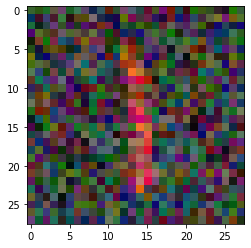

In [9]:
index = np.random.randint(0, len(x_train))
x, y, c = create_example(x_train[index], y_train[index])

print(f'digit: {y}, color: {colors[c]}')

plt.imshow(x)
plt.show()

In [10]:
#Task 3: Dataset Generator

In [11]:
def generate_data(x, y, batch_size=32):
    num_examples = len(y)
    
    while True:
        x_batch = np.zeros((batch_size, 28, 28, 3))
        y_batch = np.zeros((batch_size, ))
        c_batch = np.zeros((batch_size, ))

        for i in range(0, batch_size):
            index = np.random.randint(0, num_examples)
            image, digit, color = create_example(x[index], y[index])
            x_batch[i] = image
            y_batch[i] = digit
            c_batch[i] = color

        yield x_batch, [y_batch, c_batch]

In [12]:
#Task 4: Create Model

In [13]:
num_filters = 32

input_ = tf.keras.layers.Input(shape=(28, 28, 3), name='input')

conv_1 = tf.keras.layers.Conv2D(num_filters, 3, name='conv_1')(input_)
act_1 = tf.keras.layers.Activation('relu', name='act_1')(conv_1)

pool_1 = tf.keras.layers.MaxPool2D(4, name='pool_1')(act_1)
flat_1 = tf.keras.layers.Flatten(name='flat_1')(pool_1)

conv_2 = tf.keras.layers.Conv2D(num_filters, 3, padding='same', name='conv_2')(act_1)
act_2 = tf.keras.layers.Activation('relu', name='act_2')(conv_2)

conv_3 = tf.keras.layers.Conv2D(num_filters, 3, padding='same', name='conv_3')(act_2)
add = tf.keras.layers.Add(name='add')([act_1, conv_3])

act_3 = tf.keras.layers.Activation('relu', name='act_3')(add)
pool_2 = tf.keras.layers.MaxPool2D(4, name='pool_2')(act_3)

flat_2 = tf.keras.layers.Flatten(name='flat_2')(pool_2)

digit = tf.keras.layers.Dense(10, activation='softmax', name='digit')(flat_2)
color = tf.keras.layers.Dense(1, activation='sigmoid', name='color')(flat_1)

model = tf.keras.models.Model(input_, [digit, color])

model.compile(
    loss={
        'digit': 'sparse_categorical_crossentropy',
        'color': 'binary_crossentropy'
    },
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 26, 26, 32)   896         ['input[0][0]']                  
                                                                                                  
 act_1 (Activation)             (None, 26, 26, 32)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 26, 26, 32)   9248        ['act_1[0][0]']                  
                                                                                              

In [14]:
tf.keras.utils.plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [15]:
#Task 5: Training the Model

In [16]:
class Logger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        digit_accuracy = logs.get('digit_accuracy')
        color_accuracy = logs.get('color_accuracy')
        val_digit_accuracy = logs.get('val_digit_accuracy')
        val_color_accuracy = logs.get('val_color_accuracy')
        print('='*30, epoch + 1, '='*30)
        print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
        print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')

In [17]:
train_gen = generate_data(x_train, y_train)
val_gen = generate_data(x_test, y_test)

_ = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=200,
    validation_steps=100,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
        Logger()
    ],
    verbose=False
)

C:\Users\baazo\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


============================== 1 ==============================
digit_accuracy: 0.53, color_accuracy: 0.97
val_digit_accuracy: 0.84, val_color_accuracy: 1.00
============================== 2 ==============================
digit_accuracy: 0.87, color_accuracy: 1.00
val_digit_accuracy: 0.92, val_color_accuracy: 1.00
============================== 3 ==============================
digit_accuracy: 0.92, color_accuracy: 1.00
val_digit_accuracy: 0.94, val_color_accuracy: 1.00
============================== 4 ==============================
digit_accuracy: 0.94, color_accuracy: 1.00
val_digit_accuracy: 0.94, val_color_accuracy: 1.00
============================== 5 ==============================
digit_accuracy: 0.95, color_accuracy: 1.00
val_digit_accuracy: 0.96, val_color_accuracy: 1.00
============================== 6 ==============================
digit_accuracy: 0.95, color_accuracy: 1.00
val_digit_accuracy: 0.96, val_color_accuracy: 1.00
============================== 7 ===================

In [18]:
%tensorboard --logdir logs

In [19]:
#Task 6: Final Predictions

In [20]:
def test_model(show=True):
    x, [y, c] = next(test)
    
    preds = model.predict(x)
    pred_digit = np.argmax(preds[0])
    pred_color = int(preds[1] > 0.5)
    gt_digit = int(y[0])
    gt_color = int(c[0])
    
    plt.imshow(x[0])
    if show:
        print(f'GT: {gt_digit}, {colors[gt_color]}')
        print(f'Pr: {pred_digit}, {colors[pred_color]}')
        plt.show()
    else:
        col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
        plt.ylabel(f'GT: {gt_digit}, {colors[gt_color]}', color=col)
        plt.xlabel(f'Pr: {pred_digit}, {colors[pred_color]}', color=col)
        plt.xticks([])
        plt.yticks([])


test = generate_data(x_test, y_test, batch_size=1)

GT: 3, red
Pr: 3, red


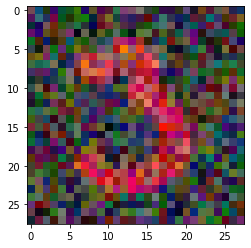

In [21]:
test_model()

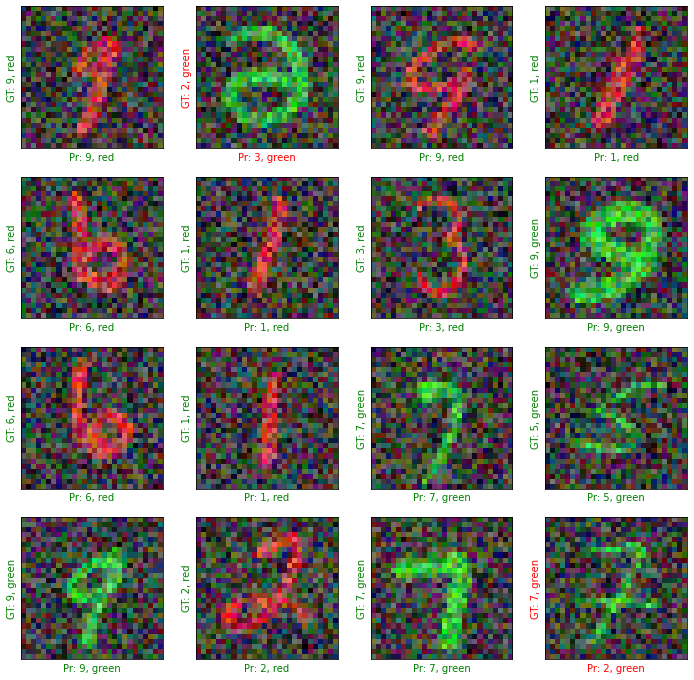

In [22]:
plt.figure(figsize=(12, 12))
for i in range(0, 16):
    plt.subplot(4, 4, i + 1)
    test_model(False)
plt.show()